# Classez des images à l'aide d'algorithmes de Deep Learning - Model perso

### Sommaire


* [1. Importation des librairies, définition des fonctions et définition des chemins](#1)
    * [1.1 Importation des librairies](#1_1)
    * [1.2 Définition des fonctions](#1_2)
    * [1.3 Définition des chemins vers les répertoires](#1_3)
* [2. Création des datasets (Train, Validation et Test)](#2)
* [3. Premier réseau CNN](#3)
    * [3.1 Non optimisé](#3_1)
    * [3.2 Optimisation du modèle](#3_2)
* [4. Data augmentation](#4)
    * [4.1 Test unitaire](#4_1)
    * [4.2 Data augmentation sur l'ensemble des données](#4_2)
* [5. Second réseau CNN (avec Data augmentation)](#5)
    * [5.1 Sur le modèle optimisé précédemment](#5_1)
    * [5.2 Sur un modèle avec une couche de convolution en plus](#5_2)
    * [5.3 Optimisation du modèle avec une couche de convolution en plus](#5_3)
* [6. Choix du modèle et essai sur les 120 races de chiens](#6)
    * [6.1 Essai du modèle sans optimisation](#6_1)
    * [6.2 Optimisation du modèle](#6_2)

## 1. Importation des librairies, définition des fonctions et définition des chemins <a class="anchor" id="1"></a>

### 1.1 Importation des librairies <a class="anchor" id="1_1"></a>

In [1]:
import os
import numpy as np
import cv2
import pandas as pd

# Temps d'exécution
import time

# Graphiques
import matplotlib.pyplot as plt

# Tensorflow keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2
from keras.optimizers import Adam
import keras_tuner as kt 

### 1.2 Définition des fonctions <a class="anchor" id="1_2"></a>

In [2]:
def show_modified_img(img, datagen):
    """Fonction pour afficher les modifications de la data augmentation"""
    num_images = 4
    num_cols = 4
    num_rows = num_images // num_cols
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 8))
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    
    # Redimensionner l'image pour correspondre à la forme attendue
    img = np.expand_dims(img, axis=0)
    
    for i, ax in enumerate(axs.flat):
        if i < num_images:
            ax.imshow(array_to_img(next(datagen.flow(img, batch_size=1))[0]))
            ax.axis('off')
            
    plt.show()
    
# Créer un DataFrame vide pour stocker les résultats des modèles
df_results = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss', "Temps d'entraînement du modèle"])
    
def score(df_results, model_name, accuracy, loss, temps_execution):
    """Fonction pour enregistrer les différentes métriques des modèles dans un DataFrame"""
    # Ajouter les résultats du modèle au DataFrame global en supprimant les potentiels doublons
    df_results.loc[df_results.shape[0]] = [model_name, accuracy, loss, temps_execution]
    df_results = df_results.drop_duplicates(subset=['Model'])

    return df_results
    
def eval_model(model, test_loss, test_accuracy, model_history):
    """Fonction pour évaluer le modèle 
    avec graphiques (courbe de perte et courbe d'apprentissage)"""
    # Afficher la précision du modèle sur les données de test
    print(f'Précision sur les données de test : {test_accuracy*100:.2f}%')
    
    # Afficher les courbes d'apprentissage (perte et précision)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['loss'], label="Perte d'entraînement")
    plt.plot(model_history.history['val_loss'], label='Perte de validation')
    plt.legend()
    plt.title('Courbe de Perte')

    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['accuracy'], label="Précision d'entraînement")
    plt.plot(model_history.history['val_accuracy'], label='Précision de validation')
    plt.legend()
    plt.title('Courbe de Précision')

    plt.show()

### 1.3 Définition des chemins vers les répertoires <a class="anchor" id="1_3"></a>

In [3]:
# Chemin vers les répertoires
data_dir = 'Images_preprocessed/'

train_dir = 'Images_preprocessed/train'
test_dir = 'Images_preprocessed/test'
validation_dir = 'Images_preprocessed/validation'

## 2. Création des datasets (Train, Validation et Test) <a class="anchor" id="2"></a>

In [4]:
# Liste des sous-répertoires dans le répertoire d'entraînement
class_names = os.listdir(train_dir)
class_names

['affenpinscher',
 'Afghan_hound',
 'African_hunting_dog',
 'Airedale',
 'American_Staffordshire_terrier',
 'Appenzeller',
 'Australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'Bedlington_terrier',
 'Bernese_mountain_dog',
 'black',
 'Blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'Border_collie',
 'Border_terrier',
 'borzoi',
 'Boston_bull',
 'Bouvier_des_Flandres',
 'boxer',
 'Brabancon_griffon',
 'briard',
 'Brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'Cardigan',
 'Chesapeake_Bay_retriever',
 'Chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly',
 'Dandie_Dinmont',
 'dhole',
 'dingo',
 'Doberman',
 'English_foxhound',
 'English_setter',
 'English_springer',
 'EntleBucher',
 'Eskimo_dog',
 'flat',
 'French_bulldog',
 'German_shepherd',
 'German_short',
 'giant_schnauzer',
 'golden_retriever',
 'Gordon_setter',
 'Greater_Swiss_Mountain_dog',
 'Great_Dane',
 'Great_Pyrenees',
 'groenendael',
 'Ibizan_hound',
 'Irish_setter',
 'Irish_terrier',
 'Irish_water_s

In [5]:
# Nombre de classes (nombre de sous-répertoires)
nb_classes = len(class_names)
print(f'Le jeu de données contient {nb_classes} races de chiens.')

Le jeu de données contient 120 races de chiens.


In [6]:
selection_classes = ['Chihuahua', 'Doberman', 'golden_retriever']
nb_select_classes = len(selection_classes)
print(f'Nous avons choisis {nb_select_classes} races de chiens pour tester le modèle, à savoir {selection_classes}.')

Nous avons choisis 3 races de chiens pour tester le modèle, à savoir ['Chihuahua', 'Doberman', 'golden_retriever'].


In [7]:
# Créer un objet ImageDataGenerator pour la normalisation
datagen = ImageDataGenerator(rescale=1./255)

# Définir les générateurs de données pour l'ensemble d'entraînement et l'ensemble de test
train_generator_select = datagen.flow_from_directory(train_dir,
                                                     batch_size=40,
                                                     target_size=(224, 224),
                                                     color_mode='grayscale',
                                                     class_mode='categorical', 
                                                     classes=selection_classes)

validation_generator_select = datagen.flow_from_directory(validation_dir,
                                                          batch_size=40,
                                                          target_size=(224, 224),
                                                          color_mode='grayscale',
                                                          class_mode='categorical',
                                                          classes=selection_classes)

test_generator_select = datagen.flow_from_directory(test_dir,
                                                    batch_size=40,
                                                    target_size=(224, 224),
                                                    color_mode='grayscale',
                                                    class_mode='categorical', 
                                                    classes=selection_classes)

Found 288 images belonging to 3 classes.
Found 73 images belonging to 3 classes.
Found 91 images belonging to 3 classes.


In [8]:
# Obtenir un lot de données à partir du générateur
X_train, y_train = train_generator_select.next()

# Afficher les dimensions du lot de données
print("Dimensions du lot de données d'entraînement :")
print(' ')
print("Images (batch_size, height, width, channels) :", X_train.shape)
print("Labels (batch_size, nb_classes) :", y_train.shape)

Dimensions du lot de données d'entraînement :
 
Images (batch_size, height, width, channels) : (40, 224, 224, 1)
Labels (batch_size, nb_classes) : (40, 3)


## 3. Premier réseau CNN <a class="anchor" id="3"></a>

### 3.1 Non optimisé <a class="anchor" id="3_1"></a>

In [9]:
# Créer un modèle séquentiel
CNN_model = Sequential()

# Ajouter une couche de convolution avec 32 filtres de taille 3x3, une fonction d'activation eLU et une bordure 'same'
CNN_model.add(Conv2D(32, (3, 3), activation='elu', input_shape=(224, 224, 1), padding = 'same'))

# Ajouter une couche de pooling (max pooling) avec une fenêtre de pooling de taille 2x2
CNN_model.add(MaxPooling2D((2, 2)))

# Ajouter une autre couche de convolution avec 64 filtres de taille 3x3 et une fonction d'activation eLU
CNN_model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))

# Ajouter une autre couche de pooling (max pooling)
CNN_model.add(MaxPooling2D((2, 2)))

# Ajouter une autre couche de convolution avec 128 filtres de taille 3x3 et une fonction d'activation eLU
CNN_model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))

# Ajouter une autre couche de pooling (max pooling)
CNN_model.add(MaxPooling2D((2, 2)))

# Ajouter une autre couche de convolution avec 256 filtres de taille 3x3 et une fonction d'activation eLU
CNN_model.add(Conv2D(256, (3, 3), activation='elu', padding='same'))

# Ajouter une autre couche de pooling (max pooling)
CNN_model.add(MaxPooling2D((2, 2)))

# Aplatir les features en un seul vecteur
CNN_model.add(Flatten())

# Ajouter une couche fully connected avec 256 neurones et une fonction d'activation eLU
CNN_model.add(Dense(256, activation='elu'))

# Ajouter une couche de sortie avec le nombre de classes et une fonction d'activation softmax
CNN_model.add(Dense(nb_select_classes, activation='softmax'))

# Compiler le modèle avec un optimisateur, une fonction de perte et des métriques
CNN_model.compile(optimizer='adamax', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

# Afficher un résumé du modèle
CNN_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)     

In [10]:
# Entraîner le modèle CNN sur les données d'entraînement
epochs = 20

# Enregistrement du temps actuel
start_time = time.time()

CNN_history = CNN_model.fit(train_generator_select,
                            epochs=epochs,
                            validation_data=validation_generator_select, 
                            shuffle=True)

# Calcul du temps d'exécution
execution_time = time.time() - start_time

Epoch 1/20


8/8 [==============================] - 4s 481ms/step - loss: 6.1102 - accuracy: 0.3090 - val_loss: 1.3724 - val_accuracy: 0.3288
Epoch 2/20
8/8 [==============================] - 3s 469ms/step - loss: 1.1276 - accuracy: 0.3715 - val_loss: 1.1988 - val_accuracy: 0.3151
Epoch 3/20
8/8 [==============================] - 3s 412ms/step - loss: 1.0747 - accuracy: 0.4757 - val_loss: 1.1438 - val_accuracy: 0.3699
Epoch 4/20
8/8 [==============================] - 3s 406ms/step - loss: 1.0673 - accuracy: 0.4479 - val_loss: 1.0789 - val_accuracy: 0.4247
Epoch 5/20
8/8 [==============================] - 3s 420ms/step - loss: 1.0013 - accuracy: 0.5243 - val_loss: 1.0643 - val_accuracy: 0.4247
Epoch 6/20
8/8 [==============================] - 3s 409ms/step - loss: 0.9668 - accuracy: 0.5556 - val_loss: 1.0345 - val_accuracy: 0.4932
Epoch 7/20
8/8 [==============================] - 3s 447ms/step - loss: 0.9682 - accuracy: 0.5486 - val_loss: 1.0366 - val_accuracy: 0.4658
Epoch 8/20
8/8 [==

3/3 - 0s - loss: 0.9391 - accuracy: 0.4945 - 294ms/epoch - 98ms/step
Précision sur les données de test : 49.45%


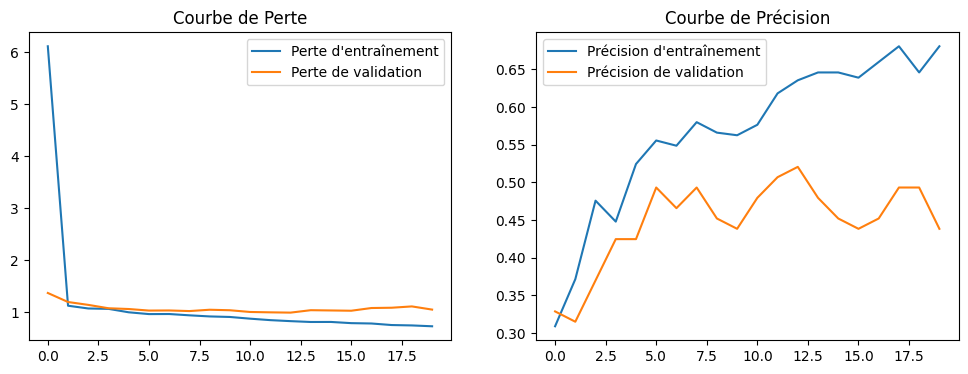

In [11]:
# Evaluer le modèle sur les données de test
test_loss, test_accuracy = CNN_model.evaluate(test_generator_select, verbose=2)

# Evaluation du modèle avec la fonction d'évaluation 'eval_model'
eval_model(CNN_model, test_loss, test_accuracy, CNN_history)

In [12]:
# Enregistrement des scores du modèle
score(df_results, 'CNN_model', test_accuracy, test_loss, execution_time)

df_results.loc[df_results['Model'] == 'CNN_model']

,Model,Accuracy,Loss,Temps d'entraînement du modèle
0,CNN_model,0.494505,0.93913,68.554517


### 3.2 Optimisation du modèle <a class="anchor" id="3_2"></a>

Nous allons chercher à optimiser un maximum d'hyperparamètres de notre réseau de neurones avec Keras Tuner.
A savoir : l'activation, le nombre de filtres, le nombre de neurones de la couche dense, le taux de dropout, le learning rate et la fonction de perte.

In [13]:
def model_builder(hp):
    """Fonction pour créer l'hypermodèle dans lequel on définit les hyperparamètres"""
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), padding='same'))
    model.add(MaxPooling2D(2, 2))
    
    # Trouver le bon nombre de filtres sur le deuxième Conv2D
    hp_filters = hp.Choice('num_filters_1', values=[32, 64], default=64)
    model.add(Conv2D(filters=hp_filters, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(2, 2))
    
    # Trouver le bon nombre de filtres sur le troisième Conv2D
    hp_filters = hp.Choice('num_filters_2', values=[64, 128], default=128)
    model.add(Conv2D(filters=hp_filters, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Flatten())
    
    # Trouver le bon nombre de neurones pour la couche dense
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units, activation='relu'))
    
    # Trouver le bon taux de Dropout
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.7, default=0.25, step=0.05)
    model.add(Dropout(rate=hp_dropout))
    
    model.add(Dense(nb_select_classes, activation='softmax'))
    
    # Trouver le bon learning_rate pour l'optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Trouver la bonne fonction de perte
    hp_loss = hp.Choice('loss_function', values=['sparse_categorical_crossentropy', 'kl_divergence'], 
                        default='sparse_categorical_crossentropy')
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss=hp_loss,
                  metrics=['accuracy'])
    
    return model

In [14]:
# Instancier le réglage et effectuer l'hypertuning
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     directory='my_dir',
                     max_epochs = 40,
                     project_name='hyper_tuning_1')

# Exécuter la recherche des hyperparamètres
tuner.search(datagen.flow_from_directory(train_dir,
                                         batch_size=40,
                                         target_size=(224, 224),
                                         color_mode='grayscale',
                                         class_mode='sparse', 
                                         classes=selection_classes),  
             validation_data = datagen.flow_from_directory(validation_dir,
                                                           batch_size=40,
                                                           target_size=(224, 224),
                                                           color_mode='grayscale',
                                                           class_mode='sparse',
                                                           classes=selection_classes), 
             epochs=40, 
             callbacks=[EarlyStopping(monitor='val_accuracy',
                                       patience=5)])

# Afficher les meilleurs hyperparamètres
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
La recherche des hyperparamètres est terminée.\n
Le meilleur nombre de filtres pour la deuxième couche de convolution : {best_hps.get('num_filters_1')}.\n
Le meilleur nombre de filtres pour la troisième couche de convolution : {best_hps.get('num_filters_2')}.\n
Le meilleur nombre de neurones pour la couche dense est : {best_hps.get('units')}.\n 
Le meilleur taux de dropout est : {best_hps.get('dropout')}.\n
Le meilleur learning rate pour l'optimizer est : {best_hps.get('learning_rate')}.\n
Et la meilleure fonction de perte est : {best_hps.get('loss_function')}.
""")

Reloading Tuner from my_dir\hyper_tuning_1\tuner0.json
Found 288 images belonging to 3 classes.
Found 73 images belonging to 3 classes.

La recherche des hyperparamètres est terminée.

Le meilleur nombre de filtres pour la deuxième couche de convolution : 64.

Le meilleur nombre de filtres pour la troisième couche de convolution : 128.

Le meilleur nombre de neurones pour la couche dense est : 384.
 
Le meilleur taux de dropout est : 0.45000000000000007.

Le meilleur learning rate pour l'optimizer est : 0.0001.

Et la meilleure fonction de perte est : sparse_categorical_crossentropy.



In [15]:
# Contruire le modèle avec les meilleurs hyperparamètres et afficher un résumé du modèle
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 28, 28, 128)      

In [16]:
# Entraîner le modèle CNN sur les données d'entraînement
epochs = 40

# Enregistrement du temps actuel
start_time = time.time()

best_model_history = best_model.fit(datagen.flow_from_directory(train_dir,
                                                                batch_size=40,
                                                                target_size=(224, 224),
                                                                class_mode='sparse',
                                                                color_mode='grayscale',
                                                                classes=selection_classes),
                                    epochs=epochs,
                                    validation_data=datagen.flow_from_directory(validation_dir,
                                                                                batch_size=40,
                                                                                target_size=(224, 224),
                                                                                class_mode='sparse',
                                                                                color_mode='grayscale',
                                                                                classes=selection_classes), 
                                    shuffle=True,
                                    callbacks=[EarlyStopping(monitor='val_accuracy', patience=10)])

# Calcul du temps d'exécution
execution_time = time.time() - start_time

Found 288 images belonging to 3 classes.
Found 73 images belonging to 3 classes.
Epoch 1/40
8/8 [==============================] - 4s 463ms/step - loss: 1.1167 - accuracy: 0.3611 - val_loss: 1.0653 - val_accuracy: 0.5068
Epoch 2/40
8/8 [==============================] - 4s 443ms/step - loss: 1.0663 - accuracy: 0.4375 - val_loss: 1.0360 - val_accuracy: 0.4247
Epoch 3/40
8/8 [==============================] - 4s 465ms/step - loss: 0.9826 - accuracy: 0.5660 - val_loss: 1.0170 - val_accuracy: 0.4384
Epoch 4/40
8/8 [==============================] - 4s 458ms/step - loss: 0.9244 - accuracy: 0.5729 - val_loss: 1.0057 - val_accuracy: 0.4521
Epoch 5/40
8/8 [==============================] - 4s 442ms/step - loss: 0.8732 - accuracy: 0.6076 - val_loss: 1.0357 - val_accuracy: 0.4110
Epoch 6/40
8/8 [==============================] - 4s 445ms/step - loss: 0.8707 - accuracy: 0.6007 - val_loss: 1.0005 - val_accuracy: 0.4247
Epoch 7/40
8/8 [==============================] - 4s 450ms/step - loss: 0.7925 

In [17]:
# Nouveau test generator
test_generator = datagen.flow_from_directory(test_dir,
                                             batch_size=40,
                                             target_size=(224, 224),
                                             color_mode='grayscale',
                                             class_mode='sparse',
                                             classes=selection_classes)

Found 91 images belonging to 3 classes.


3/3 - 0s - loss: 0.8878 - accuracy: 0.5714 - 269ms/epoch - 90ms/step
Précision sur les données de test : 57.14%


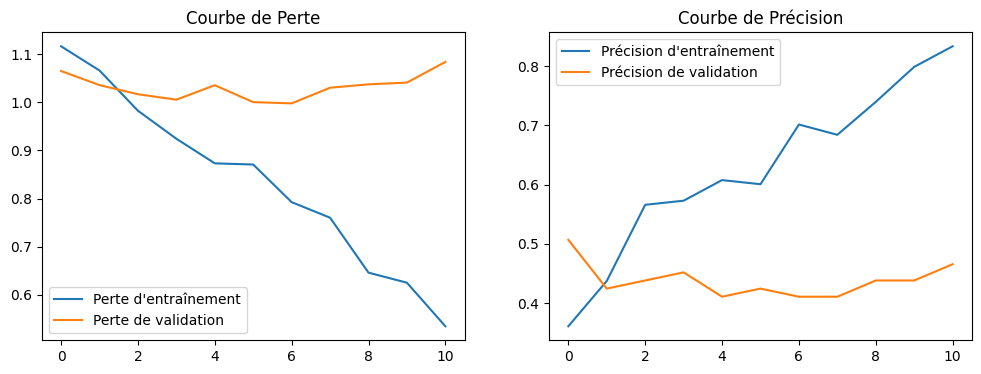

In [18]:
# Evaluer le modèle sur les données de test
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=2)

# Evaluation du modèle avec la fonction d'évaluation 'eval_model'
eval_model(best_model, test_loss, test_accuracy, best_model_history)

In [19]:
# Enregistrement des scores du modèle
score(df_results, 'best_model', test_accuracy, test_loss, execution_time)

df_results.loc[df_results['Model'] == 'best_model']

,Model,Accuracy,Loss,Temps d'entraînement du modèle
1,best_model,0.571429,0.887784,41.051292


## 4. Data augmentation <a class="anchor" id="4"></a>

### 4.1 Test unitaire <a class="anchor" id="4_1"></a>

Image à l'origine :


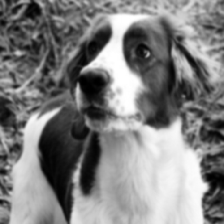

In [20]:
# Choisir une image aléatoirement
sample_race_dir = os.path.join(train_dir, np.random.choice(os.listdir(train_dir), size=1)[0])
sample_img = np.random.choice(os.listdir(sample_race_dir), size=1)[0]

# Charger l'image d'origine
img_path = os.path.join(sample_race_dir, sample_img)
img = load_img(img_path, target_size=(224, 224))

# Afficher l'image
print("Image à l'origine :")
img

Résultat de la data augmentation suite à rotation :


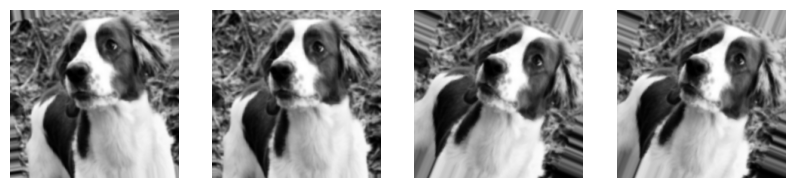

In [21]:
# Créer un objet ImageDataGenerator pour la data augmentation avec rotation
datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=30,
                            fill_mode='nearest')

# Afficher les modifications
print("Résultat de la data augmentation suite à rotation :")
show_modified_img(img, datagen)

Résultat de la data augmentation suite à déplacement vertical et horizontal :


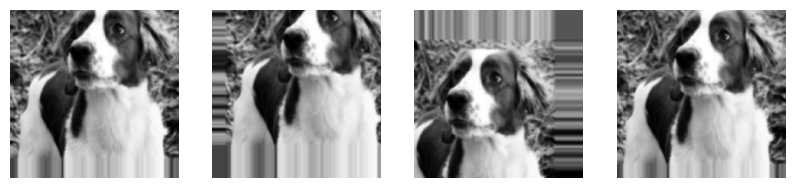

In [22]:
# Créer un objet ImageDataGenerator pour la data augmentation avec déplacement vertical et horizontal
datagen = ImageDataGenerator(rescale=1./255,
                            width_shift_range=50,
                            height_shift_range=50,
                            fill_mode='nearest')

# Afficher les modifications
print("Résultat de la data augmentation suite à déplacement vertical et horizontal :")
show_modified_img(img, datagen)

Résultat de la data augmentation suite à modification de la luminosité :


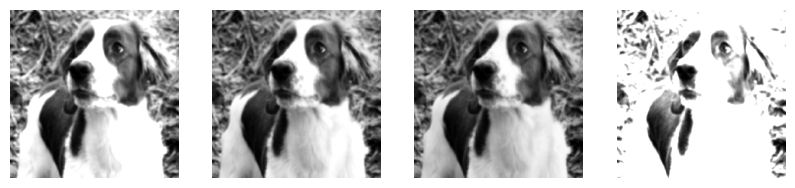

In [23]:
# Créer un objet ImageDataGenerator pour la data augmentation
datagen = ImageDataGenerator(rescale=1./255,
                             brightness_range=(0, 4),
                             fill_mode='nearest')

# Afficher les modifications
print("Résultat de la data augmentation suite à modification de la luminosité :")
show_modified_img(img, datagen)

Résultat de la data augmentation suite à étirement de l'image :


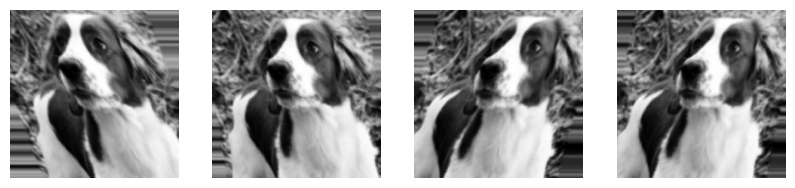

In [24]:
# Créer un objet ImageDataGenerator pour la data augmentation
datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=30,
                             fill_mode='nearest')

# Afficher les modifications
print("Résultat de la data augmentation suite à étirement de l'image :")
show_modified_img(img, datagen)

Résultat de la data augmentation avec zoom sur l'image :


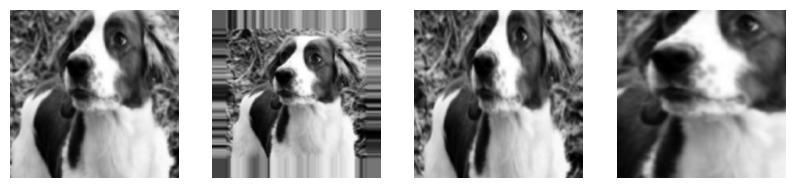

In [25]:
# Créer un objet ImageDataGenerator pour la data augmentation
datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.5,
                             fill_mode='nearest')

# Afficher les modifications
print("Résultat de la data augmentation avec zoom sur l'image :")
show_modified_img(img, datagen)

Résultat de la data augmentation suite à changement horizontal ou vertical :


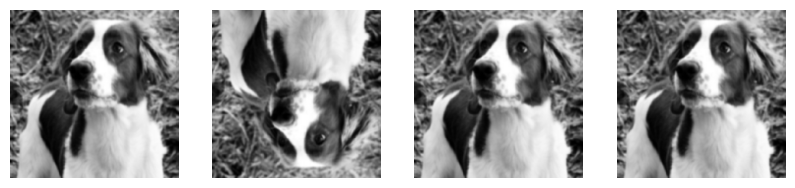

In [26]:
# Créer un objet ImageDataGenerator pour la data augmentation
datagen = ImageDataGenerator(rescale=1./255,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='nearest')

# Afficher les modifications
print("Résultat de la data augmentation suite à changement horizontal ou vertical :")
show_modified_img(img, datagen)

### 4.2 Data augmentation sur l'ensemble des données <a class="anchor" id="4_2"></a>

In [27]:
augmented_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=30, # 56.04%
#                                        width_shift_range=50, # 52.75%
#                                        height_shift_range=50, #57.14% attention chute validation pas au dessus de 40%
#                                        brightness_range=(0, 4), # 42.86% 
                                       shear_range=30, #51.65%
#                                        zoom_range=0.5, #51.65%
#                                        horizontal_flip=True, #54.95%
#                                        vertical_flip=True, #47.25% et stable
                                      )

Nous ne pouvons pas utiliser toutes les possibilités en Data augmentation car certaines ont tendances à réduire le score du modèle.

## 5. Second réseau CNN (avec Data augmentation) <a class="anchor" id="5"></a>

### 5.1 Sur le modèle optimisé précédemment <a class="anchor" id="5_1"></a>

In [28]:
# Instancier le réglage et effectuer l'hypertuning du modèle optimisé avec la data augmentation
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     directory='my_dir',
                     max_epochs = 40,
                     project_name='hyper_tuning_2')

# Exécuter la recherche des hyperparamètres avec augmented_datagen
tuner.search(augmented_datagen.flow_from_directory(train_dir,
                                                   batch_size=40,
                                                   target_size=(224, 224),
                                                   color_mode='grayscale',
                                                   class_mode='sparse',
                                                   classes=selection_classes),  
             validation_data = augmented_datagen.flow_from_directory(validation_dir,
                                                                     batch_size=40,
                                                                     target_size=(224, 224),
                                                                     color_mode='grayscale',
                                                                     class_mode='sparse',
                                                                     classes=selection_classes), 
             epochs=40, 
             callbacks=[EarlyStopping(monitor='val_accuracy',
                                       patience=5)])

# Afficher les meilleurs hyperparamètres
best_hps_aug = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
La recherche des hyperparamètres est terminée.\n
Le meilleur nombre de filtres pour la deuxième couche de convolution : {best_hps_aug.get('num_filters_1')}.\n
Le meilleur nombre de filtres pour la troisième couche de convolution : {best_hps_aug.get('num_filters_2')}.\n
Le meilleur nombre de neurones pour la couche dense est : {best_hps_aug.get('units')}.\n 
Le meilleur taux de dropout est : {best_hps_aug.get('dropout')}.\n
Le meilleur learning rate pour l'optimizer est : {best_hps_aug.get('learning_rate')}.\n
Et la meilleure fonction de perte est : {best_hps_aug.get('loss_function')}.
""")

Trial 90 Complete [00h 00m 19s]
val_accuracy: 0.3287671208381653

Best val_accuracy So Far: 0.5479452013969421
Total elapsed time: 00h 26m 41s

La recherche des hyperparamètres est terminée.

Le meilleur nombre de filtres pour la deuxième couche de convolution : 64.

Le meilleur nombre de filtres pour la troisième couche de convolution : 128.

Le meilleur nombre de neurones pour la couche dense est : 96.
 
Le meilleur taux de dropout est : 0.30000000000000004.

Le meilleur learning rate pour l'optimizer est : 0.001.

Et la meilleure fonction de perte est : sparse_categorical_crossentropy.



In [29]:
# Contruire le modèle avec les meilleurs hyperparamètres et afficher un résumé du modèle
best_model_aug = tuner.hypermodel.build(best_hps_aug)
best_model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 28, 128)      

In [30]:
epochs = 40

# Enregistrement du temps actuel
start_time = time.time()

# Entraîner le modèle CNN sur les données d'entraînement
best_model_history_aug = best_model_aug.fit(augmented_datagen.flow_from_directory(train_dir,
                                                                                  batch_size=40,
                                                                                  target_size=(224, 224),
                                                                                  class_mode='sparse',
                                                                                  color_mode='grayscale',
                                                                                  classes=selection_classes),
                                            epochs=epochs,
                                            validation_data=augmented_datagen.flow_from_directory(validation_dir,
                                                                                                  batch_size=40,
                                                                                                  target_size=(224, 224),
                                                                                                  class_mode='sparse',
                                                                                                  color_mode='grayscale',
                                                                                                  classes=selection_classes),
                                            shuffle=True,
                                            callbacks=[EarlyStopping(monitor='val_accuracy', patience=10)])

# Calcul du temps d'exécution
execution_time = time.time() - start_time

Found 288 images belonging to 3 classes.
Found 73 images belonging to 3 classes.
Epoch 1/40
8/8 [==============================] - 4s 403ms/step - loss: 1.4430 - accuracy: 0.3264 - val_loss: 1.1036 - val_accuracy: 0.3288
Epoch 2/40
8/8 [==============================] - 3s 362ms/step - loss: 1.0991 - accuracy: 0.3750 - val_loss: 1.0972 - val_accuracy: 0.4247
Epoch 3/40
8/8 [==============================] - 3s 375ms/step - loss: 1.0951 - accuracy: 0.3958 - val_loss: 1.0923 - val_accuracy: 0.3973
Epoch 4/40
8/8 [==============================] - 3s 371ms/step - loss: 1.0822 - accuracy: 0.4306 - val_loss: 1.0770 - val_accuracy: 0.4110
Epoch 5/40
8/8 [==============================] - 3s 373ms/step - loss: 1.0559 - accuracy: 0.4097 - val_loss: 1.0401 - val_accuracy: 0.3836
Epoch 6/40
8/8 [==============================] - 3s 421ms/step - loss: 1.0452 - accuracy: 0.4062 - val_loss: 1.0331 - val_accuracy: 0.4658
Epoch 7/40
8/8 [==============================] - 3s 371ms/step - loss: 1.0211 

3/3 - 0s - loss: 0.9389 - accuracy: 0.5495 - 276ms/epoch - 92ms/step
Précision sur les données de test : 54.95%


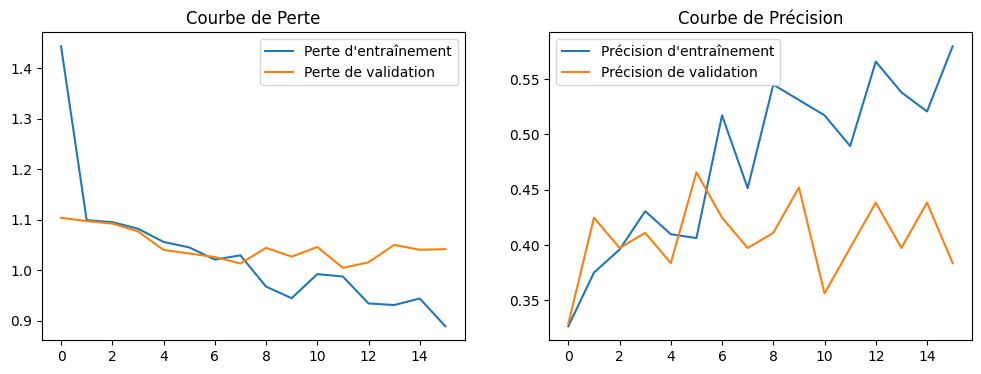

In [31]:
# Evaluer le modèle sur les données de test
test_loss, test_accuracy = best_model_aug.evaluate(test_generator, verbose=2)

# Evaluation du modèle avec la fonction d'évaluation 'eval_model'
eval_model(best_model_aug, test_loss, test_accuracy, best_model_history_aug)

In [32]:
# Enregistrement des scores du modèle
score(df_results, 'best_model_aug', test_accuracy, test_loss, execution_time)

df_results.loc[df_results['Model'] == 'best_model_aug']

,Model,Accuracy,Loss,Temps d'entraînement du modèle
2,best_model_aug,0.549451,0.938868,49.609229


### 5.2 Sur un modèle avec une couche de convolution en plus <a class="anchor" id="5_2"></a>

In [33]:
# Créer un modèle séquentiel
CNN_model_aug = Sequential()

# Ajouter une couche de convolution avec 32 filtres de taille 3x3, une fonction d'activation ReLU et une bordure 'same'
CNN_model_aug.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), padding='same', kernel_regularizer=l2(0.01)))

# Ajouter une couche de pooling (max pooling) avec une fenêtre de pooling de taille 2x2
CNN_model_aug.add(MaxPooling2D((2, 2)))

# Ajouter une autre couche de convolution avec 64 filtres de taille 3x3 et une fonction d'activation ReLU
CNN_model_aug.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))

# Ajouter une autre couche de pooling (max pooling)
CNN_model_aug.add(MaxPooling2D((2, 2)))

# Ajouter une autre couche de convolution avec 128 filtres de taille 3x3 et une fonction d'activation ReLU
CNN_model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))

# Ajouter une autre couche de pooling (max pooling)
CNN_model_aug.add(MaxPooling2D((2, 2)))

# Ajouter une autre couche de convolution avec 256 filtres de taille 3x3 et une fonction d'activation ReLU
CNN_model_aug.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))

# Ajouter une autre couche de pooling (max pooling)
CNN_model_aug.add(MaxPooling2D((2, 2)))

# Aplatir les features en un seul vecteur
CNN_model_aug.add(Flatten())

# Ajouter une couche fully connected avec 256 neurones et une fonction d'activation ReLU
CNN_model_aug.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))

# Ajouter une couche de dropout pour réduire le sur-apprentissage
CNN_model_aug.add(Dropout(0.5))

# Ajouter une couche de sortie avec le nombre de classes et une fonction d'activation softmax
CNN_model_aug.add(Dense(nb_select_classes, activation='softmax'))

# Compiler le modèle avec un optimisateur, une fonction de perte et des métriques
CNN_model_aug.compile(optimizer='adam', 
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Afficher un résumé du modèle
CNN_model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 28, 28, 128)      

In [34]:
# Entraîner le modèle CNN sur les données d'entraînement
epochs = 40

# Enregistrement du temps actuel
start_time = time.time()

CNN_history = CNN_model_aug.fit(train_generator_select,
                                epochs = epochs,
                                validation_data = validation_generator_select, 
                                shuffle = True,
                                callbacks=EarlyStopping(patience=10))

# Calcul du temps d'exécution
execution_time = time.time() - start_time

Epoch 1/40
8/8 [==============================] - 4s 445ms/step - loss: 6.3994 - accuracy: 0.3090 - val_loss: 4.1722 - val_accuracy: 0.3288
Epoch 2/40
8/8 [==============================] - 3s 413ms/step - loss: 3.6575 - accuracy: 0.3403 - val_loss: 3.2250 - val_accuracy: 0.4521
Epoch 3/40
8/8 [==============================] - 3s 406ms/step - loss: 2.8957 - accuracy: 0.3715 - val_loss: 2.5076 - val_accuracy: 0.4110
Epoch 4/40
8/8 [==============================] - 3s 474ms/step - loss: 2.2565 - accuracy: 0.4167 - val_loss: 2.0428 - val_accuracy: 0.4110
Epoch 5/40
8/8 [==============================] - 3s 428ms/step - loss: 1.9742 - accuracy: 0.4514 - val_loss: 1.8595 - val_accuracy: 0.4658
Epoch 6/40
8/8 [==============================] - 3s 410ms/step - loss: 1.7597 - accuracy: 0.5069 - val_loss: 1.6738 - val_accuracy: 0.4521
Epoch 7/40
8/8 [==============================] - 3s 418ms/step - loss: 1.5850 - accuracy: 0.5000 - val_loss: 1.5273 - val_accuracy: 0.5068
Epoch 8/40
8/8 [====

3/3 - 0s - loss: 1.3955 - accuracy: 0.5055 - 301ms/epoch - 100ms/step
Précision sur les données de test : 50.55%


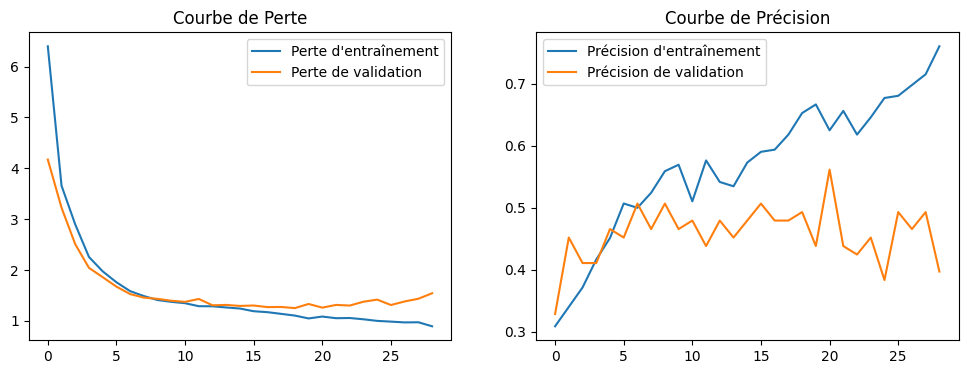

In [35]:
# Evaluer le modèle sur les données de test
test_loss, test_accuracy = CNN_model_aug.evaluate(test_generator_select, verbose=2)

# Evaluation du modèle avec la fonction d'évaluation 'eval_model'
eval_model(CNN_model_aug, test_loss, test_accuracy, CNN_history)

In [36]:
# Enregistrement des scores du modèle
score(df_results, 'CNN_model_aug', test_accuracy, test_loss, execution_time)

df_results.loc[df_results['Model'] == 'CNN_model_aug']

,Model,Accuracy,Loss,Temps d'entraînement du modèle
3,CNN_model_aug,0.505495,1.395484,101.563106


### 5.3 Optimisation du modèle avec une couche de convolution en plus <a class="anchor" id="5_3"></a>

In [39]:
def model_builder_aug(hp):
    """Fonction pour créer l'hypermodèle dans lequel on définit les hyperparamètres"""
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), padding='same'))
    model.add(MaxPooling2D(2, 2))
    
    # Trouver le bon nombre de filtres sur le deuxième Conv2D
    hp_filters = hp.Choice('num_filters_1', values=[32, 64], default=64)
    model.add(Conv2D(filters=hp_filters, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(2, 2))
    
    # Trouver le bon nombre de filtres sur le troisième Conv2D
    hp_filters = hp.Choice('num_filters_2', values=[64, 128], default=128)
    model.add(Conv2D(filters=hp_filters, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(2, 2))
    
    # Trouver le bon nombre de filtres sur le quatrième Conv2D
    hp_filters = hp.Choice('num_filters_3', values=[128, 256], default=256)
    model.add(Conv2D(filters=hp_filters, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Flatten())
    
    # Trouver le bon nombre de neurones pour la couche dense
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units, activation='relu'))
    
    # Trouver le bon taux de Dropout
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.7, default=0.25, step=0.05)
    model.add(Dropout(rate=hp_dropout))
    
    model.add(Dense(nb_select_classes, activation='softmax'))
    
    # Trouver le bon learning_rate pour l'optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Trouver la bonne fonction de perte
    hp_loss = hp.Choice('loss_function', values=['sparse_categorical_crossentropy', 'kl_divergence'], 
                        default='sparse_categorical_crossentropy')
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss=hp_loss,
                  metrics=['accuracy'])
    
    return model

In [40]:
# Instancier le réglage et effectuer l'hypertuning
tuner = kt.Hyperband(model_builder_aug,
                     objective='val_accuracy',
                     directory='my_dir',
                     max_epochs = 40,
                     project_name='hyper_tuning_3')

# Exécuter la recherche des hyperparamètres
tuner.search(augmented_datagen.flow_from_directory(train_dir,
                                                   batch_size=40,
                                                   target_size=(224, 224),
                                                   color_mode='grayscale',
                                                   class_mode='sparse',
                                                   classes=selection_classes),  
             validation_data = augmented_datagen.flow_from_directory(validation_dir,
                                                                     batch_size=40,
                                                                     target_size=(224, 224),
                                                                     color_mode='grayscale',
                                                                     class_mode='sparse',
                                                                     classes=selection_classes), 
             epochs=40, 
             callbacks=[EarlyStopping(monitor='val_accuracy',
                                       patience=5)])

# Afficher les meilleurs hyperparamètres
best_hps_aug2 = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
La recherche des hyperparamètres est terminée.\n
Le meilleur nombre de filtres pour la deuxième couche de convolution : {best_hps_aug2.get('num_filters_1')}.\n
Le meilleur nombre de filtres pour la troisième couche de convolution : {best_hps_aug2.get('num_filters_2')}.\n
Le meilleur nombre de filtres pour la quatrième couche de convolution : {best_hps_aug2.get('num_filters_3')}.\n
Le meilleur nombre de neurones pour la couche dense est : {best_hps_aug2.get('units')}.\n 
Le meilleur taux de dropout est : {best_hps_aug2.get('dropout')}.\n
Le meilleur learning rate pour l'optimizer est : {best_hps_aug2.get('learning_rate')}.\n
Et la meilleure fonction de perte est : {best_hps_aug2.get('loss_function')}.
""")

Trial 90 Complete [00h 00m 58s]
val_accuracy: 0.5205479264259338

Best val_accuracy So Far: 0.5616438388824463
Total elapsed time: 00h 24m 05s

La recherche des hyperparamètres est terminée.

Le meilleur nombre de filtres pour la deuxième couche de convolution : 32.

Le meilleur nombre de filtres pour la troisième couche de convolution : 64.

Le meilleur nombre de filtres pour la quatrième couche de convolution : 128.

Le meilleur nombre de neurones pour la couche dense est : 32.
 
Le meilleur taux de dropout est : 0.2.

Le meilleur learning rate pour l'optimizer est : 0.001.

Et la meilleure fonction de perte est : sparse_categorical_crossentropy.



In [41]:
# Contruire le modèle avec les meilleurs hyperparamètres et afficher un résumé du modèle
best_model_aug2 = tuner.hypermodel.build(best_hps_aug2)
best_model_aug2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 28, 28, 64)       

In [42]:
epochs = 40

# Enregistrement du temps actuel
start_time = time.time()

# Entraîner le modèle CNN sur les données d'entraînement
best_model_history_aug2 = best_model_aug2.fit(augmented_datagen.flow_from_directory(train_dir,
                                                                                    batch_size=40,
                                                                                    target_size=(224, 224),
                                                                                    class_mode='sparse',
                                                                                    color_mode='grayscale',
                                                                                    classes=selection_classes),
                                              epochs=epochs,
                                              validation_data=augmented_datagen.flow_from_directory(validation_dir,
                                                                                                    batch_size=40,
                                                                                                    target_size=(224, 224),
                                                                                                    class_mode='sparse',
                                                                                                    color_mode='grayscale',
                                                                                                    classes=selection_classes),
                                              shuffle=True,
                                              callbacks=[EarlyStopping(monitor='val_accuracy', patience=10)])

# Calcul du temps d'exécution
execution_time = time.time() - start_time

Found 288 images belonging to 3 classes.
Found 73 images belonging to 3 classes.
Epoch 1/40
8/8 [==============================] - 3s 290ms/step - loss: 1.1188 - accuracy: 0.3090 - val_loss: 1.0984 - val_accuracy: 0.3288
Epoch 2/40
8/8 [==============================] - 2s 261ms/step - loss: 1.0983 - accuracy: 0.3542 - val_loss: 1.0981 - val_accuracy: 0.3425
Epoch 3/40
8/8 [==============================] - 2s 258ms/step - loss: 1.0984 - accuracy: 0.3472 - val_loss: 1.0964 - val_accuracy: 0.3288
Epoch 4/40
8/8 [==============================] - 2s 259ms/step - loss: 1.0922 - accuracy: 0.4028 - val_loss: 1.0901 - val_accuracy: 0.3425
Epoch 5/40
8/8 [==============================] - 2s 261ms/step - loss: 1.0974 - accuracy: 0.3854 - val_loss: 1.0847 - val_accuracy: 0.4384
Epoch 6/40
8/8 [==============================] - 2s 265ms/step - loss: 1.0883 - accuracy: 0.3438 - val_loss: 1.0823 - val_accuracy: 0.4110
Epoch 7/40
8/8 [==============================] - 2s 261ms/step - loss: 1.0822 

3/3 - 0s - loss: 0.9708 - accuracy: 0.5275 - 211ms/epoch - 70ms/step
Précision sur les données de test : 52.75%


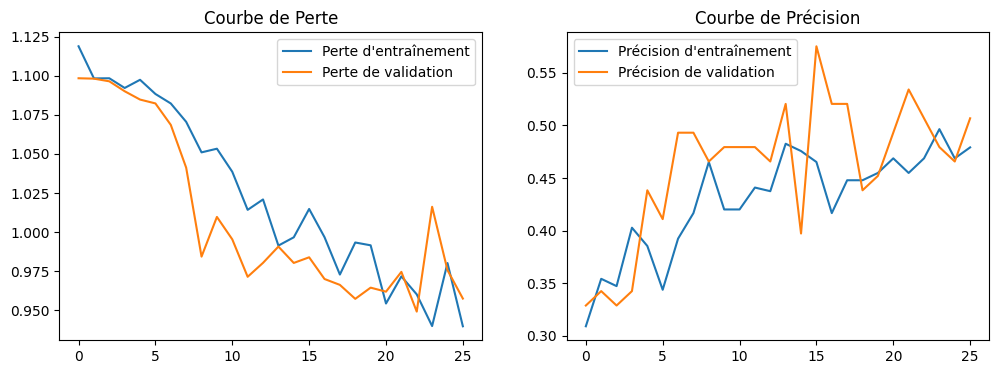

In [43]:
# Evaluer le modèle sur les données de test
test_loss, test_accuracy = best_model_aug2.evaluate(test_generator, verbose=2)

# Evaluation du modèle avec la fonction d'évaluation 'eval_model'
eval_model(best_model_aug2, test_loss, test_accuracy, best_model_history_aug2)

In [44]:
# Enregistrement des scores du modèle
score(df_results, 'best_model_aug2', test_accuracy, test_loss, execution_time)

df_results.loc[df_results['Model'] == 'best_model_aug2']

,Model,Accuracy,Loss,Temps d'entraînement du modèle
4,best_model_aug2,0.527473,0.970796,56.935886


## 6. Choix du modèle et essai sur les 120 races de chiens <a class="anchor" id="6"></a>

In [47]:
# Affichage des scores des modèles
df_results.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Loss,Temps d'entraînement du modèle
1,best_model,0.571429,0.887784,41.051292
2,best_model_aug,0.549451,0.938868,49.609229
4,best_model_aug2,0.527473,0.970796,56.935886
3,CNN_model_aug,0.505495,1.395484,101.563106
0,CNN_model,0.494505,0.939130,68.554517


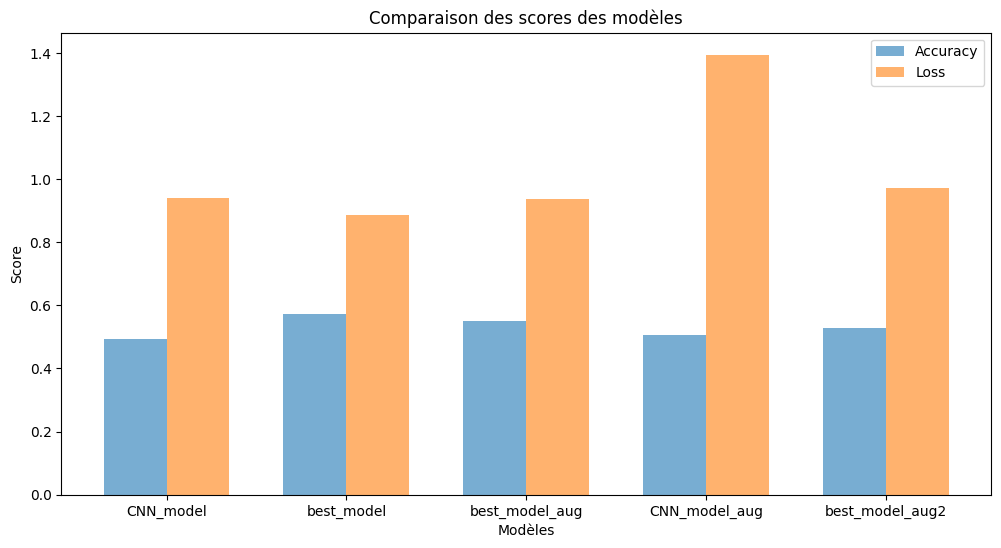

In [71]:
df_resultsv1 = df_results[(df_results['Model'] != 'model_120') & (df_results['Model'] != 'best_model_120')]

# Créer une liste d'indices pour chaque modèle
model_indices = np.arange(len(df_resultsv1['Model']))

# Créer une figure et un axe pour les graphiques
fig, ax = plt.subplots(figsize=(12, 6))

# Largeur des barres
bar_width = 0.35

# Tracer les résultats
f1_bars = ax.bar(model_indices - bar_width/2, df_resultsv1['Accuracy'], bar_width, label='Accuracy', alpha=0.6)
jaccard_bars = ax.bar(model_indices + bar_width/2, df_resultsv1['Loss'], bar_width, label='Loss', alpha=0.6)

# Ajoutez des étiquettes et une légende
ax.set_xlabel('Modèles')
ax.set_ylabel('Score')
ax.set_title('Comparaison des scores des modèles')
ax.set_xticks(model_indices)
ax.set_xticklabels(df_resultsv1['Model'])
ax.legend()
plt.show()

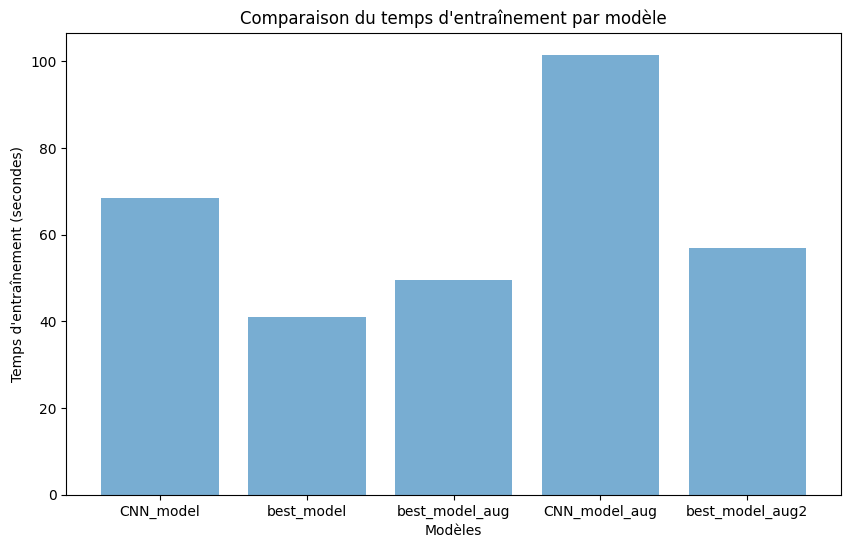

In [70]:
# Créer une figure et un axe pour les graphiques
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer le temps d'exécution pour chaque modèle
ax.bar(df_resultsv1['Model'], df_resultsv1["Temps d'entraînement du modèle"], label="Temps d'entraînement", alpha=0.6)

# Ajouter des étiquettes et une légende
ax.set_xlabel('Modèles')
ax.set_ylabel("Temps d'entraînement (secondes)")
ax.set_title("Comparaison du temps d'entraînement par modèle")

# Afficher le graphique
plt.show()

Ici, nous constatons que la précision est meilleure pour 'best_model', mais ce modèle présentait une tendance au surapprentissage (overfitting).

En augmentant les données, nous avons réussi à atténuer ce phénomène, rendant le modèle plus stable avec l'ajout d'une couche de convolution supplémentaire.

Nous allons donc opter pour le modèle 'best_model_aug2', qui affiche une précision de 0,527 sur un échantillon de 3 races de chiens, avant de le tester sur l'ensemble des 120 races du dataset.

### 6.1 Essai du modèle sans optimisation <a class="anchor" id="6_1"></a>

In [63]:
# Reprennons le modèle avec les meilleurs hyperparamètres et en l'adaptant pour les 120 races de chiens
model_120 = Sequential()
model_120.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), padding='same'))
model_120.add(MaxPooling2D(2, 2))
model_120.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
model_120.add(MaxPooling2D(2, 2))
model_120.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model_120.add(MaxPooling2D(2, 2))
model_120.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
model_120.add(MaxPooling2D(2, 2))
model_120.add(Flatten())
model_120.add(Dense(units=32, activation='relu'))
model_120.add(Dropout(rate=0.2))
model_120.add(Dense(nb_classes, activation='softmax'))
    
model_120.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_120.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 28, 28, 64)       

Pour les 120 races de chiens, nous devrons ajuster le nombre d'epochs (avec l'utilisation d'un arrêt anticipé grâce à 'EarlyStopping') ainsi que la taille du lot ('batch_size').

In [64]:
epochs = 100

# Enregistrement du temps actuel
start_time = time.time()

# Entraîner le modèle CNN sur les données d'entraînement
model_history_120 = model_120.fit(augmented_datagen.flow_from_directory(train_dir,
                                                                        batch_size=150,
                                                                        target_size=(224, 224),
                                                                        class_mode='sparse',
                                                                        color_mode='grayscale'),
                                        epochs=epochs,
                                        validation_data=augmented_datagen.flow_from_directory(validation_dir,
                                                                                              batch_size=150,
                                                                                              target_size=(224, 224),
                                                                                              class_mode='sparse',
                                                                                              color_mode='grayscale'),
                                        shuffle=True,
                                        callbacks=[EarlyStopping(monitor='val_accuracy', patience=10)])

# Calcul du temps d'exécution
execution_time = time.time() - start_time

Found 13091 images belonging to 120 classes.
Found 3327 images belonging to 120 classes.
Epoch 1/100
88/88 [==============================] - 97s 1s/step - loss: 4.7873 - accuracy: 0.0092 - val_loss: 4.7857 - val_accuracy: 0.0114
Epoch 2/100
88/88 [==============================] - 96s 1s/step - loss: 4.7783 - accuracy: 0.0125 - val_loss: 4.7523 - val_accuracy: 0.0144
Epoch 3/100
88/88 [==============================] - 96s 1s/step - loss: 4.7326 - accuracy: 0.0150 - val_loss: 4.6979 - val_accuracy: 0.0147
Epoch 4/100
88/88 [==============================] - 98s 1s/step - loss: 4.6867 - accuracy: 0.0163 - val_loss: 4.6660 - val_accuracy: 0.0183
Epoch 5/100
88/88 [==============================] - 98s 1s/step - loss: 4.6589 - accuracy: 0.0183 - val_loss: 4.6477 - val_accuracy: 0.0177
Epoch 6/100
88/88 [==============================] - 96s 1s/step - loss: 4.6518 - accuracy: 0.0196 - val_loss: 4.6350 - val_accuracy: 0.0195
Epoch 7/100
88/88 [==============================] - 98s 1s/step 

Found 4162 images belonging to 120 classes.
28/28 - 7s - loss: 4.5609 - accuracy: 0.0344 - 7s/epoch - 263ms/step
Précision sur les données de test : 3.44%


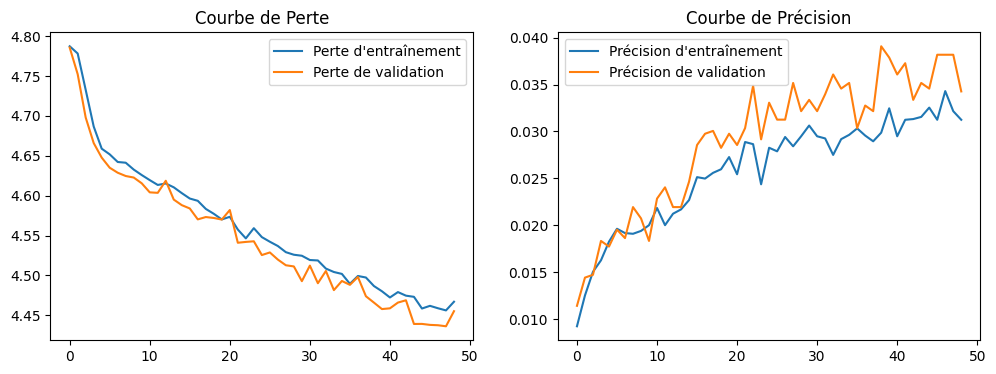

In [65]:
# Evaluer le modèle sur les données de test
test_loss, test_accuracy = model_120.evaluate(datagen.flow_from_directory(test_dir,
                                                                          batch_size=150,
                                                                          target_size=(224, 224),
                                                                          color_mode='grayscale',
                                                                          class_mode='sparse'),
                                              verbose=2)

# Evaluation du modèle avec la fonction d'évaluation 'eval_model'
eval_model(model_120, test_loss, test_accuracy, model_history_120)

In [66]:
# Enregistrement des scores du modèle
score(df_results, 'model_120', test_accuracy, test_loss, execution_time)

df_results.loc[df_results['Model'] == 'model_120']

C:\Users\Basti\AppData\Local\Temp\ipykernel_6584\2616909710.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results.loc[df_results.shape[0]] = [model_name, accuracy, loss, temps_execution]


,Model,Accuracy,Loss,Temps d'entraînement du modèle
6,model_120,0.034358,4.560908,4780.735914


### 6.2 Optimisation du modèle <a class="anchor" id="6_2"></a>

In [56]:
def model_builder_aug2(hp):
    """Fonction pour créer l'hypermodèle dans lequel on définit les hyperparamètres"""
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), padding='same'))
    model.add(MaxPooling2D(2, 2))
    
    # Trouver le bon nombre de filtres sur le deuxième Conv2D
    hp_filters = hp.Choice('num_filters_1', values=[32, 64], default=64)
    model.add(Conv2D(filters=hp_filters, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(2, 2))
    
    # Trouver le bon nombre de filtres sur le troisième Conv2D
    hp_filters = hp.Choice('num_filters_2', values=[64, 128], default=128)
    model.add(Conv2D(filters=hp_filters, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(2, 2))
    
    # Trouver le bon nombre de filtres sur le quatrième Conv2D
    hp_filters = hp.Choice('num_filters_3', values=[128, 256], default=256)
    model.add(Conv2D(filters=hp_filters, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Flatten())
    
    # Trouver le bon nombre de neurones pour la couche dense
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units, activation='relu'))
    
    # Trouver le bon taux de Dropout
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.7, default=0.25, step=0.05)
    model.add(Dropout(rate=hp_dropout))
    
    model.add(Dense(nb_classes, activation='softmax'))
    
    # Trouver le bon learning_rate pour l'optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Trouver la bonne fonction de perte
    hp_loss = hp.Choice('loss_function', values=['sparse_categorical_crossentropy', 'kl_divergence'], 
                        default='sparse_categorical_crossentropy')
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss=hp_loss,
                  metrics=['accuracy'])
    
    return model

In [57]:
# Instancier le réglage et effectuer l'hypertuning
tuner = kt.Hyperband(model_builder_aug2,
                     objective='val_accuracy',
                     directory='my_dir',
                     max_epochs = 40,
                     project_name='hyper_tuning_4')

# Exécuter la recherche des hyperparamètres
tuner.search(augmented_datagen.flow_from_directory(train_dir,
                                                   batch_size=150,
                                                   target_size=(224, 224),
                                                   color_mode='grayscale',
                                                   class_mode='sparse'),  
             validation_data = augmented_datagen.flow_from_directory(validation_dir,
                                                                     batch_size=150,
                                                                     target_size=(224, 224),
                                                                     color_mode='grayscale',
                                                                     class_mode='sparse'), 
             epochs=40, 
             callbacks=[EarlyStopping(monitor='val_accuracy',
                                       patience=5)])

# Afficher les meilleurs hyperparamètres
best_hps_aug3 = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
La recherche des hyperparamètres est terminée.\n
Le meilleur nombre de filtres pour la deuxième couche de convolution : {best_hps_aug3.get('num_filters_1')}.\n
Le meilleur nombre de filtres pour la troisième couche de convolution : {best_hps_aug3.get('num_filters_2')}.\n
Le meilleur nombre de filtres pour la quatrième couche de convolution : {best_hps_aug3.get('num_filters_3')}.\n
Le meilleur nombre de neurones pour la couche dense est : {best_hps_aug3.get('units')}.\n 
Le meilleur taux de dropout est : {best_hps_aug3.get('dropout')}.\n
Le meilleur learning rate pour l'optimizer est : {best_hps_aug3.get('learning_rate')}.\n
Et la meilleure fonction de perte est : {best_hps_aug3.get('loss_function')}.
""")

Trial 90 Complete [00h 15m 30s]
val_accuracy: 0.010519987903535366

Best val_accuracy So Far: 0.0769461989402771
Total elapsed time: 16h 52m 26s

La recherche des hyperparamètres est terminée.

Le meilleur nombre de filtres pour la deuxième couche de convolution : 32.

Le meilleur nombre de filtres pour la troisième couche de convolution : 128.

Le meilleur nombre de filtres pour la quatrième couche de convolution : 256.

Le meilleur nombre de neurones pour la couche dense est : 416.
 
Le meilleur taux de dropout est : 0.5.

Le meilleur learning rate pour l'optimizer est : 0.001.

Et la meilleure fonction de perte est : sparse_categorical_crossentropy.



In [58]:
# Contruire le modèle avec les meilleurs hyperparamètres et afficher un résumé du modèle
best_model_120 = tuner.hypermodel.build(best_hps_aug3)
best_model_120.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 128)       36992     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 28, 28, 128)      

In [59]:
epochs = 100

# Enregistrement du temps actuel
start_time = time.time()

# Entraîner le modèle CNN sur les données d'entraînement
best_model_120_history = best_model_120.fit(augmented_datagen.flow_from_directory(train_dir,
                                                                                  batch_size=150,
                                                                                  target_size=(224, 224),
                                                                                  class_mode='sparse',
                                                                                  color_mode='grayscale'),
                                            epochs=epochs,
                                            validation_data=augmented_datagen.flow_from_directory(validation_dir,
                                                                                                  batch_size=150,
                                                                                                  target_size=(224, 224),
                                                                                                  class_mode='sparse',
                                                                                                  color_mode='grayscale'),
                                            shuffle=True,
                                            callbacks=[EarlyStopping(monitor='val_accuracy', patience=10)])

# Calcul du temps d'exécution
execution_time = time.time() - start_time

Found 13091 images belonging to 120 classes.
Found 3327 images belonging to 120 classes.
Epoch 1/100
88/88 [==============================] - 124s 1s/step - loss: 4.7884 - accuracy: 0.0110 - val_loss: 4.7664 - val_accuracy: 0.0210
Epoch 2/100
88/88 [==============================] - 123s 1s/step - loss: 4.7159 - accuracy: 0.0167 - val_loss: 4.6375 - val_accuracy: 0.0201
Epoch 3/100
88/88 [==============================] - 123s 1s/step - loss: 4.6286 - accuracy: 0.0234 - val_loss: 4.5803 - val_accuracy: 0.0234
Epoch 4/100
88/88 [==============================] - 123s 1s/step - loss: 4.5684 - accuracy: 0.0270 - val_loss: 4.5410 - val_accuracy: 0.0319
Epoch 5/100
88/88 [==============================] - 123s 1s/step - loss: 4.5295 - accuracy: 0.0320 - val_loss: 4.5189 - val_accuracy: 0.0343
Epoch 6/100
88/88 [==============================] - 123s 1s/step - loss: 4.4925 - accuracy: 0.0346 - val_loss: 4.5032 - val_accuracy: 0.0391
Epoch 7/100
88/88 [==============================] - 123s 1

Found 4162 images belonging to 120 classes.
28/28 - 11s - loss: 4.5959 - accuracy: 0.0560 - 11s/epoch - 403ms/step
Précision sur les données de test : 5.60%


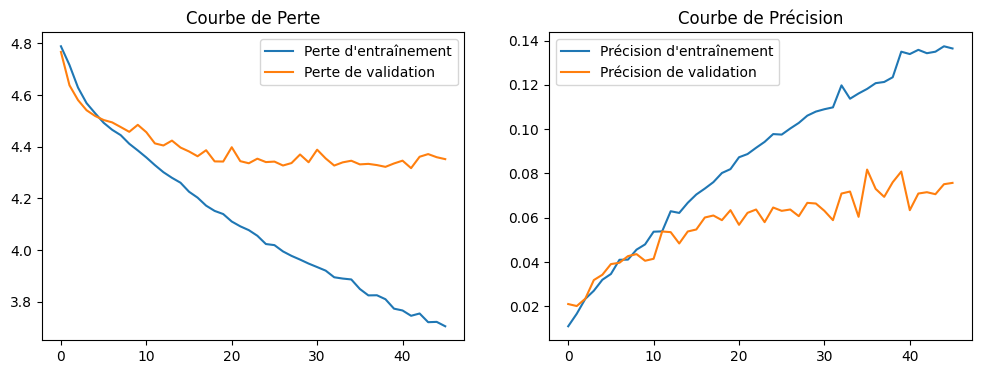

In [60]:
# Evaluer le modèle sur les données de test
test_loss, test_accuracy = best_model_120.evaluate(datagen.flow_from_directory(test_dir,
                                                                               batch_size=150,
                                                                               target_size=(224, 224),
                                                                               color_mode='grayscale',
                                                                               class_mode='sparse'), 
                                                    verbose=2)

# Evaluation du modèle avec la fonction d'évaluation 'eval_model'
eval_model(best_model_120, test_loss, test_accuracy, best_model_120_history)

In [61]:
# Enregistrement des scores du modèle
score(df_results, 'best_model_120', test_accuracy, test_loss, execution_time)

df_results.loc[df_results['Model'] == 'best_model_120']

,Model,Accuracy,Loss,Temps d'entraînement du modèle
7,best_model_120,0.055983,4.595861,5700.605637


In [72]:
df_results

,Model,Accuracy,Loss,Temps d'entraînement du modèle
0,CNN_model,0.494505,0.939130,68.554517
1,best_model,0.571429,0.887784,41.051292
2,best_model_aug,0.549451,0.938868,49.609229
3,CNN_model_aug,0.505495,1.395484,101.563106
4,best_model_aug2,0.527473,0.970796,56.935886
7,best_model_120,0.055983,4.595861,5700.605637
6,model_120,0.034358,4.560908,4780.735914


In [74]:
df_results_120 = df_results[(df_results['Model']=='model_120') | (df_results['Model']=='best_model_120')]
df_results_120

,Model,Accuracy,Loss,Temps d'entraînement du modèle
7,best_model_120,0.055983,4.595861,5700.605637
6,model_120,0.034358,4.560908,4780.735914


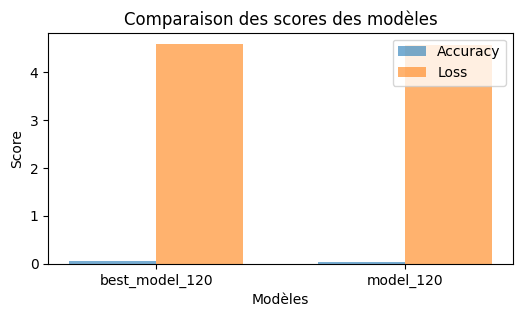

In [80]:
# Créer une liste d'indices pour chaque modèle
model_indices = np.arange(len(df_results_120['Model']))

# Créer une figure et un axe pour les graphiques
fig, ax = plt.subplots(figsize=(6, 3))

# Largeur des barres
bar_width = 0.35

# Tracer les résultats
f1_bars = ax.bar(model_indices - bar_width/2, df_results_120['Accuracy'], bar_width, label='Accuracy', alpha=0.6)
jaccard_bars = ax.bar(model_indices + bar_width/2, df_results_120['Loss'], bar_width, label='Loss', alpha=0.6)

# Ajoutez des étiquettes et une légende
ax.set_xlabel('Modèles')
ax.set_ylabel('Score')
ax.set_title('Comparaison des scores des modèles')
ax.set_xticks(model_indices)
ax.set_xticklabels(df_results_120['Model'])
ax.legend()
plt.show()